# Import modules

In [1]:
import os
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt

from tqdm import tqdm

import urllib.request as urllib2
import time
from bs4 import BeautifulSoup, SoupStrainer



# Mount google drive

In [2]:
# References:
# [1] https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a
# [2] https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab
# [3] https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

try:
    from google.colab import drive
    from google.colab import files
    # import torch
    # import torch.nn as nn
    # import torch.nn.functional as F
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:

    # mount google drive 
    drive.mount('/content/gdrive/', force_remount=True)

    import os
    #change directory
    try:
        os.chdir('/content/gdrive/MyDrive/ADC')

    except:
        os.chdir('/content/gdrive/MyDrive/MCED/ADC')

Mounted at /content/gdrive/


In [3]:
# working directory
wdir = os.getcwd()

DF_MSTheses_dir = wdir +'/DF_MSTHESES/'

In [4]:

dict_unis = {
            'UPorto'    : "rabertoup",          # "Repositório Aberto da Universidade do Porto (34682)"
            'UCoimbra'  : "estudogl",           # "Estudo Geral - Universidade de Coimbra (20368)"
            'ULisboa'   : "ul",                 # "Repositório da Universidade de Lisboa (17436)"
            'UNLisboa'  : "run",                # "Repositório Institucional da UNL (14415)"
            'UMinho'    : "rum",                # "RepositóriUM - Universidade do Minho (13845)"
            'UAveiro'   : "ria",                # "RIA - Repositório Institucional da Universidade de Aveiro (13254)"
            'UTL'       : "rutl",               # "Repositório da UTL (12863)"
            'UCP'       : "veritati",           # "Veritati - Repositório Institucional da Universidade Católica Portuguesa (9289)"
            # 'ISCTE'     : "iscte",              # "Repositório ISCTE (8605)"
            # 'IPPorto'   : "recipp",             # "Repositório Científico do Instituto Politécnico do Porto (7858)"
            'UBI'       : "ubibliorum",         # "uBibliorum (6998)"
            'UEvora'    : "uevora",             # "Repositório Científico da Universidade de Évora (5980)"
            'UTAD'      : "utad",               # "Repositório da UTAD (5525)"
            # 'IPLisboa'  : "ripl",               # "Repositório Científico do Instituto Politécnico de Lisboa (5232)"
            # 'Lusófona'  : "recil",              # "ReCiL - Repositório Científico Lusófona (5002)"
            # 'UFPessoa'  : "ufp",                # "Repositório Institucional - Universidade Fernando Pessoa (4170)"
            'UAlg'      : "sapientia",          # "Sapientia - Universidade do Algarve (3643)"
            # 'ISPA'      : "ispa",               # "Repositório do ISPA - Instituto Universitário (3367)"
            # 'IPCoimbra' : "ipc",                # "Instituto Politécnico de Coimbra (3053)"
            # 'ICOnline'  : "iconline"            # "IC-online (2688)"
       }

In [5]:
l_unis = dict_unis.keys()

# Auxiliary functions

In [5]:
def clean_list(l):
    return np.nan if l =='[]' else l[2:-2].split("', '")


def clean_link (s):
    s = s[2:-2].split('), (')
    l = []
    for pair in s:
        l.append(pair[1:-1].split("', '") )
    
    return l


In [6]:
# function to map collections to UO
def collection2UO(l_in, university, dict_collections):

    n_errors = 0
    l_out = []
    for collection in l_in:
        try:
            l_out.append(university + ' | ' + dict_collections[collection[0]])
        except:
            n_errors += 1
            continue

    # print(f'Entries not found in the dictionary: {n_errors}')
    return list(set(l_out))

In [7]:

def read_df (university, dir):

    # read dataframe
    df = pd.read_csv(dir +'df_MSTheses_' + university +'.csv').drop('Page', axis=1)
    print(f'Successfuly loaded {university} dataframe')

    # columns to clean
    l = ['Author','Supervisor','Title','TitleALT','Language','Date','Abstract','AbstractALT','Keywords','Faculty','Degree','Type','TID','Subject FOS']

    # clean the columns
    for col in l:
        df[col] = df[~df[col].isna()][col].apply(lambda l: clean_list(l))

    df.Collection = df.Collection.apply(lambda x: clean_link(x))

    # Dictionary of collections : UO
    try:
        df_Coll = pd.read_csv(dir + 'dict_Collections_' + university + '.csv')
        dict_Coll = dict(zip(df_Coll.Title, df_Coll.UO))
        
    except Exception as e:
        return e

    
    df['UO'] = df['Collection'].apply(lambda x: collection2UO(x, university, dict_Coll))
    # https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe
    # df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)

    df['n_UO'] = df['UO'].apply(lambda x: len(x))

    return df, dict_Coll

# Load dataframes

In [8]:
# Load dataframes

dict_df_MSTheses = {}
dict_Collections = {}

n_theses = 0

for university in dict_unis.keys():
    # read dataframe
    df, dict_Coll = read_df (university, DF_MSTheses_dir)

    dict_df_MSTheses[university] = df
    dict_Collections[university] = dict_Coll

    n_theses += len(df)

    print(f'{university} df length: {len(df)}')

print(f'Total number of MScTheses: {n_theses}')


Successfuly loaded UPorto dataframe
UPorto df length: 34611
Successfuly loaded UCoimbra dataframe
UCoimbra df length: 20356
Successfuly loaded ULisboa dataframe
ULisboa df length: 17426
Successfuly loaded UNLisboa dataframe
UNLisboa df length: 14415
Successfuly loaded UMinho dataframe
UMinho df length: 13837
Successfuly loaded UAveiro dataframe
UAveiro df length: 13248
Successfuly loaded UTL dataframe
UTL df length: 12853
Successfuly loaded UCP dataframe
UCP df length: 9281
Successfuly loaded UBI dataframe
UBI df length: 7007
Successfuly loaded UEvora dataframe
UEvora df length: 5979
Successfuly loaded UTAD dataframe
UTAD df length: 5524
Successfuly loaded UAlg dataframe
UAlg df length: 3643
Total number of MScTheses: 158180


In [ ]:
print(dict_df_MSTheses)

# Extract keywords and detect language

In [9]:
#install libraries

!pip install fasttext-langdetect==1.0.3
!pip install wget
#!pip install googletrans==3.1.0a0
!pip install langdetect
!pip install ftlanguage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.3-py3-none-any.whl (222 kB)
  Created wheel for fasttext-langdetect: filename=fasttext_langdetect-1.0.3-py3-none-any.whl size=6547 sha256=5968bffaf406446802b6f93d1044b29c6e204a2e24e3a90f7bb1e203f1c8f9f9
  Stored in directory: /root/.cache/pip/wheels/82/aa/45/6bc27c27adfea07c7ee6595dbae47b98bf5159009a9a5d1c05
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=3137861 sha256=d02f8d324168f5468b337d758f4b0d0c264edfe7b44e1a015924206484e18980
  Stored in directory: /root/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext-langdetect fasttext
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [ ]:
#!pip install textblob

In [ ]:
#!pip install polyglot

In [ ]:
#!pip install spacy_langdetect

In [25]:
#!pip install downloaded_wheel.whl

ERROR: downloaded_wheel.whl is not a valid wheel filename.


In [11]:
# import libraries
import time
import string
import wget
#from googletrans import Translator
from langdetect import detect
from ftlangdetect import detect

# language detection function
def language_detector (keyword, library):
    """
    :param keyword: string to be translated
    :param library: which library to be used if fasttext, google translate api ('google') or spacy ('spacy')
    :return: keyword language short name ('en', 'pt', 'la')
    """
    if library == 'fasttext':

      language = detect(text = keyword, low_memory = True)
      output = language['lang']

    elif library == 'google':

      translator = Translator()
      language = translator.detect(keyword)
      output = language.lang
      time.sleep(0.3)

    elif library == 'spacy':

      language = detect(keyword)
      output = language['lang']

    return output

# different than words detection function
def more_than_words (keyword):
    """
    :param keyword: string to be analysed
    :return: string without punctuation
    """
    inter = keyword.translate(str.maketrans('', '', string.punctuation))
    output = inter.replace(' ', '')

    return output

# portuguese characteres recognition function
def is_portu(keyword):
    """
    :param keyword: string to be analysed
    :return: boolean if it is a portuguese word or not
    """
    matches = ['à', 'á', 'ã', 'â', 'è', 'é', 'ê', 'í', 'õ','ó','ç', 'À', 'Á', 'Ã', 'Â', 'È', 'É', 'Ê', 'Í', 'Õ','Ó','Ç']

    if any(x in keyword for x in matches):
      output = True

    else:
      output = False

    return output


In [12]:
df_MSTheses = pd.DataFrame()


for university in dict_df_MSTheses:
    
    df_MSTheses = pd.concat([df_MSTheses, dict_df_MSTheses[university]], ignore_index=True)


# df_MSTheses.to_csv('df_MSTheses.csv', index=False)

print(f'Total number of MScTheses: {len(df_MSTheses)}')


Total number of MScTheses: 158180


In [14]:
df_MSTheses.iloc[[17]]

,URL,Author,Supervisor,Title,TitleALT,Date,Abstract,AbstractALT,Language,Keywords,Faculty,Degree,Type,TID,Subject FOS,University,Collection,UO,n_UO
17,https://repositorio-aberto.up.pt/handle/10216/...,[Joana Catarina Moreira Caetano],[Joana Catarina Moreira Caetano],[No Escritório em Casa: Influência do Eu e dos...,NaN,[2022-07-13],NaN,NaN,[por],"[Psicologia, Psychology]",[Faculdade de Psicologia e de Ciências da Educ...,[Mestrado em Psicologia],[Dissertação],[203051440],"[Ciências sociais::Psicologia, Social sciences...",UPorto,"[[FPCEUP - Dissertação, /handle/10216/6811], [...",[UPorto | FPCEUP],1


In [ ]:
#df_MSTheses.to_csv('out.csv', index=False)  

In [ ]:
special_cars = {'à':'a', 'á':'a', 'ã':'a', 'â':'a', 'ê':'e', 'é':'e', 'í':'i', 'ó':'o', 'õ':'o', 'ú':'u', 'ç':'c'}
words_w_error = {'glicómia':'glicómica'}

In [23]:
LANGUAGES = {
    'af': 'afrikaans',
    'sq': 'albanian',
    'am': 'amharic',
    'ar': 'arabic',
    'hy': 'armenian',
    'az': 'azerbaijani',
    'eu': 'basque',
    'be': 'belarusian',
    'bn': 'bengali',
    'bs': 'bosnian',
    'bg': 'bulgarian',
    'ca': 'catalan',
    'ceb': 'cebuano',
    'ny': 'chichewa',
    'zh-cn': 'chinese (simplified)',
    'zh-tw': 'chinese (traditional)',
    'co': 'corsican',
    'hr': 'croatian',
    'cs': 'czech',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'eo': 'esperanto',
    'et': 'estonian',
    'tl': 'filipino',
    'fi': 'finnish',
    'fr': 'french',
    'fy': 'frisian',
    'gl': 'galician',
    'ka': 'georgian',
    'de': 'german',
    'el': 'greek',
    'gu': 'gujarati',
    'ht': 'haitian creole',
    'ha': 'hausa',
    'haw': 'hawaiian',
    'iw': 'hebrew',
    'he': 'hebrew',
    'hi': 'hindi',
    'hmn': 'hmong',
    'hu': 'hungarian',
    'is': 'icelandic',
    'ig': 'igbo',
    'id': 'indonesian',
    'ga': 'irish',
    'it': 'italian',
    'ja': 'japanese',
    'jw': 'javanese',
    'kn': 'kannada',
    'kk': 'kazakh',
    'km': 'khmer',
    'ko': 'korean',
    'ku': 'kurdish (kurmanji)',
    'ky': 'kyrgyz',
    'lo': 'lao',
    'la': 'latin',
    'lv': 'latvian',
    'lt': 'lithuanian',
    'lb': 'luxembourgish',
    'mk': 'macedonian',
    'mg': 'malagasy',
    'ms': 'malay',
    'ml': 'malayalam',
    'mt': 'maltese',
    'mi': 'maori',
    'mr': 'marathi',
    'mn': 'mongolian',
    'my': 'myanmar (burmese)',
    'ne': 'nepali',
    'no': 'norwegian',
    'or': 'odia',
    'ps': 'pashto',
    'fa': 'persian',
    'pl': 'polish',
    'pt': 'portuguese',
    'pa': 'punjabi',
    'ro': 'romanian',
    'ru': 'russian',
    'sm': 'samoan',
    'gd': 'scots gaelic',
    'sr': 'serbian',
    'st': 'sesotho',
    'sn': 'shona',
    'sd': 'sindhi',
    'si': 'sinhala',
    'sk': 'slovak',
    'sl': 'slovenian',
    'so': 'somali',
    'es': 'spanish',
    'su': 'sundanese',
    'sw': 'swahili',
    'sv': 'swedish',
    'tg': 'tajik',
    'ta': 'tamil',
    'te': 'telugu',
    'th': 'thai',
    'tr': 'turkish',
    'uk': 'ukrainian',
    'ur': 'urdu',
    'ug': 'uyghur',
    'uz': 'uzbek',
    'vi': 'vietnamese',
    'cy': 'welsh',
    'xh': 'xhosa',
    'yi': 'yiddish',
    'yo': 'yoruba',
    'zu': 'zulu',
}

In [13]:
import time
from tqdm import tqdm
#from googletrans import Translator
#from langdetect import detect

library = 'fasttext'
dict_keywords_list = []  
flg = 0                                                       # create an empty list for keywords dictionaries

for i in tqdm(df_MSTheses.index):

  keywords = df_MSTheses.Keywords.iloc[i]                                       # select all the keywords

  if type(keywords) == list:

    keywords_pt = []
    keywords_en = []
    keywords_otr = []
    keywords_acronym = []

    for word in keywords: 

      # translator = Translator()
      # lang = translator.detect(word)
     
      # if lang.lang == 'pt':
      #   flg = 1;
      #   keywords_pt.append(word.lower())

      if is_portu(word) == True:
        flg = 1                                                                 # in case of keyword than contains ['à', 'á', 'ã', 'â', 'é', 'í', 'õ','ç']
        keywords_pt.append(word.lower())

      elif more_than_words(word).isalpha() == False:                              # in case of something different than words, keep it in keywords_Otr
        keywords_otr.append(word.lower())

      elif word.isupper() == True:                                              # in case of an acronym, it will selected as acronym keyword
        keywords_acronym.append(word.lower())

      else:
                                                                                # detect keyword language
        idiom = language_detector(word, library)
        
        if idiom == 'pt':
          flg = 1                                                        # if portuguese keyword, keep it in keywords_Pt list
          keywords_pt.append(word.lower())
        
        elif idiom == 'en':#lang.lang == 'en':                                                   # if english keyword, keep it in keywords_En list
          keywords_en.append(word.lower())

        else:                                                                   # if different from portuguese or english, keep it in keywords_Otr
          keywords_otr.append(word.lower())

      if flg == 1:
        dict_keywords = {
                          'Index': i,                                                # define a dictionary
                          'Keywords_Pt': word,
                          'Keywords_En': keywords_en,
                          'Keywords_Otr': keywords_otr,
                          'Keywords_Acro': keywords_acronym,
                          'URL': df_MSTheses.URL.iloc[i]
                        }
    
        dict_keywords_list.append(dict_keywords)                                  # append all dictionaries to the same list
      flg = 0                                    
    pass

df_keywords = pd.DataFrame.from_dict(dict_keywords_list)                        # create dataframe from a list of dictionaries
#df_keywords.set_index('Index', inplace = False)   

100%|██████████| 158180/158180 [00:38<00:00, 4112.38it/s]


In [14]:
len(dict_keywords_list)

389996

## Number of extracted keywords from (158180) master theses

In [15]:
print("Number of portuguese keywords present in 158180 Master Theses - ", len(df_keywords))

Number of portuguese keywords present in 158180 Master Theses -  389996


# Dataframe for Portuguese Keywords

In [16]:
df_kwds = df_keywords[df_keywords.columns[0:2]]

## Duplicate column

In [17]:
df_kwds['Keywords_nlp'] = df_kwds.loc[:, 'Keywords_Pt']

<ipython-input-17-20414f9e5363>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kwds['Keywords_nlp'] = df_kwds.loc[:, 'Keywords_Pt']


In [18]:
df_kwds

,Index,Keywords_Pt,Keywords_nlp
0,0,Ciências médicas e da saúde,Ciências médicas e da saúde
1,1,Outras ciências da engenharia e tecnologias,Outras ciências da engenharia e tecnologias
2,2,Ciências da educação,Ciências da educação
3,3,Ciências médicas e da saúde,Ciências médicas e da saúde
4,4,Outras ciências da engenharia e tecnologias,Outras ciências da engenharia e tecnologias
...,...,...,...
389991,158176,Época de muda,Época de muda
389992,158176,Período ovígero,Período ovígero
389993,158177,Crescimento,Crescimento
389994,158178,Época barroca,Época barroca


In [19]:
type(df_kwds)

pandas.core.frame.DataFrame

In [20]:
df_MSTheses.isna().any()

URL            False
Author         False
Supervisor      True
Title          False
TitleALT        True
Date           False
Abstract        True
AbstractALT     True
Language        True
Keywords        True
Faculty         True
Degree          True
Type           False
TID             True
Subject FOS     True
University     False
Collection     False
UO             False
n_UO           False
dtype: bool

## Sort keywords

In [21]:
df_keywords_sorted = df_kwds.sort_values('Keywords_Pt')

In [22]:
df_keywords_sorted

,Index,Keywords_Pt,Keywords_nlp
302101,126447,"""Abordagem político-institucional""","""Abordagem político-institucional"""
39505,35112,"""Comércio do Funchal""","""Comércio do Funchal"""
39503,35112,"""Comércio do Funchal""","""Comércio do Funchal"""
129046,66977,"""Design"" de nanopartículas","""Design"" de nanopartículas"
302100,126447,"""Efeitos dominó"" e ""Endaka""","""Efeitos dominó"" e ""Endaka"""
...,...,...,...
59970,41475,“espigões fibra”,“espigões fibra”
59972,41475,“espigões metálicos fundidos”,“espigões metálicos fundidos”
59990,41481,“fatores de proteção”,“fatores de proteção”
59991,41481,“ideação suicida”,“ideação suicida”


# Dictionary of Keywords

In [23]:
dict_kwds = df_kwds[df_kwds.columns[2]].to_dict()

In [24]:
len(dict_kwds)

389996

In [25]:
dict_kwds

{0: 'Ciências médicas e da saúde',
 1: 'Outras ciências da engenharia e tecnologias',
 2: 'Ciências da educação',
 3: 'Ciências médicas e da saúde',
 4: 'Outras ciências da engenharia e tecnologias',
 5: 'Outras ciências médicas',
 6: 'Ciências médicas e da saúde',
 7: 'Medicina clínica',
 8: 'Ciências médicas e da saúde',
 9: 'Engenharia electrotécnica, electrónica e informática',
 10: 'Economia e gestão',
 11: 'Ciências da educação',
 12: 'Ciências médicas e da saúde',
 13: 'Ciências da engenharia e tecnologias',
 14: 'Economia e gestão',
 15: 'Engenharia médica',
 16: 'Economia e gestão',
 17: 'Economia e gestão',
 18: 'Medicina clínica',
 19: 'Engenharia mecânica',
 20: 'Medicina clínica',
 21: 'Ciências veterinárias',
 22: 'Ciências veterinárias',
 23: 'Ciências médicas e da saúde',
 24: 'Ciências da educação',
 25: 'Outras ciências da engenharia e tecnologias',
 26: 'Ciências médicas e da saúde',
 27: 'Medicina clínica',
 28: 'Economia e gestão',
 29: 'Engenharia electrotécnica, 

# Frequency dictionary of Keywords

In [26]:
list_keywords = []
for i in dict_kwds:
  keywords = dict_kwds[i]    
  # if type(keywords) == list:
  #   for word in keywords:
  list_keywords.append(keywords)

## Sort dictionary

In [27]:
list_keywords.sort()

In [166]:
#print(list_keywords[:250])

['"Abordagem político-institucional"', '"Comércio do Funchal"', '"Comércio do Funchal"', '"Design" de nanopartículas', '"Efeitos dominó" e "Endaka"', '"Empregorismo" de Estado', '"Escudo de Protecção da Privacidade UE-EUA"', '"Estado Novo" regime', '"Estado desenvolvimentista"', '"Fluxos comerciais"', '"Fonte da Benémola"', '"IDE e ajuda japonesa"', '"O outro"', '"Pontes de conhecimento"', '"Queijo de Évora"', '"Transportes e telecomunicações"', '"Tríade".', '"Viana do Castelo"', '"anéis corneanos intraestromais"', '"cirurgia ortognática"', '"comportamentos de saúde oral"', '"disponibilidade biológica"', '"ligeira"', '"reabsorção condilar progressiva"', '"reabsorção condilar"', '"reabsorção idiopática"', '"tratamento queratocone"', '"À descoberta de pequenos cientista" (PADPC) project', '"éficiência a priori"', '(Auto)formação de professores', '(Bio)funcionalização', '(Bio)funcionalização', '(Bio)marcadores', '(Des)Centralização', '(Des)Regulamentação', '(Des)atenção', '(Des)igualdade 

In [29]:
len(list_keywords)

389996

## Frequency table

In [28]:
from itertools import groupby
results = {value: len(list(freq)) for value, freq in groupby(sorted(list_keywords))}

In [168]:
#words_w_error = {'"Estado Novo" regime':'Estado Novo regime','"Pontes de conhecimento"':'Pontes de conhecimento','"comércio do funchal"':'comércio do funchal'}

In [29]:
len(results)

133167

# Spacy similarity (deprecated)

In [193]:
#import spacy
# install Portuguese model language
#import spacy.cli

In [194]:
#spacy.cli.download("pt_core_news_lg")
#nlp = spacy.load("pt_core_news_lg")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [198]:
#wd1_test = nlp('Acidente vascular cerebral (AVC) - Factores de risco')
#wd2_test = nlp('Acidente vascular cerebral - Factores de risco')
#print(wd1_test.similarity(wd2_test))

0.8066281499418577


# Cosine similarity

In [30]:
import math
import re
from collections import Counter

In [31]:
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [32]:
WORD = re.compile(r"\w+")

def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

In [37]:
len(df_kwds)

389996

In [33]:
df_kwds = df_kwds.sort_values('Keywords_nlp')
df_kwds.reset_index(drop=True,inplace=True)

In [36]:
def update_df(word1, word2):
  #df_kwds.at[index, 'Keywords_New'] = word1 
  df = df_kwds.loc[df_kwds['Keywords_nlp'] == word2]
  for index, row in df.iterrows():
    df_kwds.at[index, 'Keywords_nlp'] = word1

In [ ]:
# iterate dataframe
n = len(df_kwds)
j = 0

for index, row in df_kwds.iterrows():
  j = j + 1
  # word one
  #mti = row['Index']
  wd1 = row['Keywords_nlp']

  i = 1
  while i <= 10:
    res = 0
    
    if len(df_kwds) > (index+i):
      ind = index + i
      
      # In case of index higher than dataframe size
      if ind > n:
        i = 20
      
      else :

        # Get word form next row
        wd2 = df_kwds.at[df_kwds.index[ind], 'Keywords_nlp']
        
        # Vectorize words to comapre
        vector1 = text_to_vector(wd1.lower())
        vector2 = text_to_vector(wd2.lower())
        
        # Compare both words with cosine similarity
        res = get_cosine(vector1, vector2)

        # Similarity is equal or higher than 92.5%
        if (res >= 0.925):

          # Get frequency of each word on frquency table
          wd1_freq = results.get(wd1)
          wd2_freq = results.get(wd2)
          
          # Case keywords are similar
          if  wd1 == wd2: # and wstr == '': 
            pass

          # Case first keyword is more frequent than similar word 
          elif wd1_freq >= wd2_freq: # and wstr == '':
            
            # Call function
            update_df(wd1, wd2)
            
          # Case second keyword is more frequent than similar word 
          elif wd1_freq < wd2_freq: #and wstr == '':
            
            update_df(wd2, wd1)
             
    # Last row comparison
    else:
      df_kwds.at[index, 'Keywords_nlp'] = wd1
    
    i = i + 1
  # if j % 25000 == 0:
  #   print(j)

In [88]:
len(df_kwds['Keywords_nlp'].unique())

129187

In [ ]:
df1 = df_kwds[['Index','Keywords_Pt']]

df2 = df_keywords[['Index','URL']]

mergedf = pd.merge(df1, df2, on='Index', how='outer').drop_duplicates()

In [87]:

mergedf.to_csv('kewords_nlp.csv')  

# Cloud of Words 

In [ ]:
!pip install wordcloud

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [79]:
# Formating keywords to avoid beeing splitted
df1['Keywords_Pt'] = df1['Keywords_Pt'].str.replace(' ', '~').str.replace('"', '').str.replace('-', '~')

<ipython-input-79-c53d427bce77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Keywords_Pt'] = df1['Keywords_Pt'].str.replace(' ', '~').str.replace('"', '').str.replace('-', '~')


In [ ]:
df1

In [81]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from PIL import Image
from os import path
import os
import random

# Dataset
df1

# Checking for NaN values
df1.isna().sum()

#Creating the text variable
text = df1.to_string()

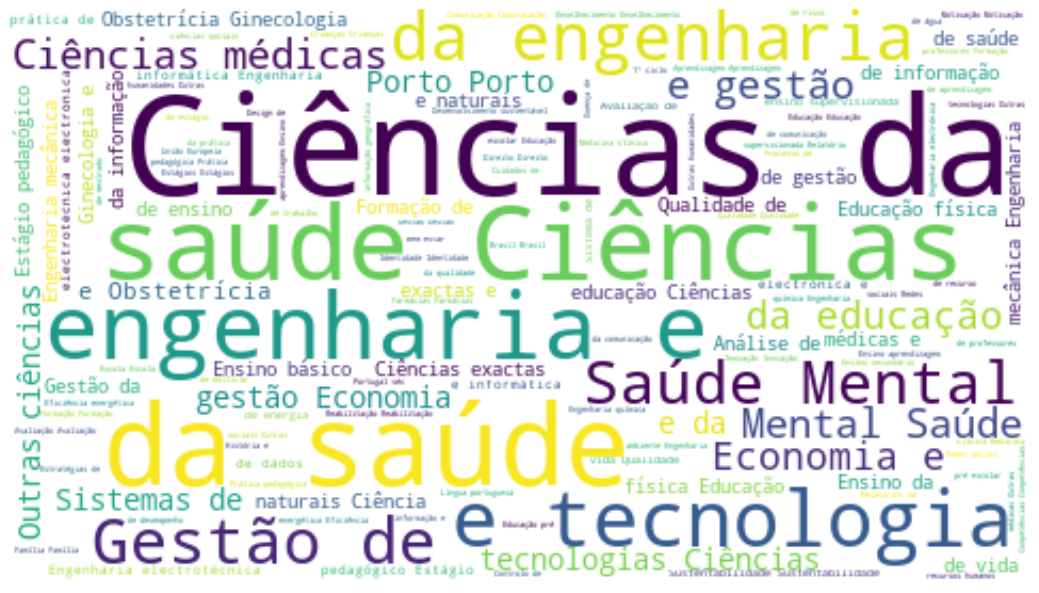

In [83]:
# Creating word_cloud with text as argument in .generate() method
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

#mask = np.array(Image.open(path.join(d, "cio_ai_intelligence_idea.png")))
word_cloud = WordCloud(collocations = True, background_color = 'white').generate(text)

# Display the generated Word Cloud
fig = plt.figure()
fig.set_size_inches(16.5, 9.75, forward=True)
fig.set_dpi(80)

ax = fig.add_subplot(111)
ax.imshow(word_cloud, interpolation='bilinear', aspect = 'auto')
ax.axis("off")

# store default colored image
default_colors = word_cloud.to_array()

#ax.set_title('WordCloud')

#plt.imshow(word_cloud.recolor(color_func=default_colors, random_state=3),interpolation="bilinear") #grey_color_func
plt.imshow(default_colors, interpolation="bilinear")